In [1]:
# Install necessary libraries
!pip install pandas matplotlib seaborn scikit-learn

In [2]:
# Import libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set the style for seaborn
sns.set(style="whitegrid")

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Step 1: Load and Combine Data
# -----------------------------
# Explanation:
# We will traverse through each subfolder, read the 'result.json' file, extract the relevant metrics and hyperparameters, and combine them into a single DataFrame for analysis.

# Specify the path to the main folder containing subfolders of embedding models
main_folder_path = '/content/drive/MyDrive/octis_model_results'

# Initialize an empty list to store data from all models
data_list = []

# Traverse through each subfolder
for embeddings_model in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, embeddings_model)
    result_file_path = os.path.join(subfolder_path, 'result.json')

    # Check if 'result.json' exists in the subfolder
    if os.path.exists(result_file_path):
        # Read the JSON file
        with open(result_file_path, 'r') as file:
            result_data = json.load(file)

        # Extract hyperparameters and metrics
        num_iterations = len(result_data['f_val'])
        for i in range(num_iterations):
            # Skip iterations with failed runs
            if result_data['f_val'][i] == -1 or result_data['dict_model_runs']['0_TopicDiversity'][f'iteration_{i}'][0] == -1:
                continue

            data_point = {
                'Embeddings_Model': embeddings_model,
                'Iteration': i,
                'Coherence': result_data['f_val'][i],
                'Topic_Diversity': result_data['dict_model_runs']['0_TopicDiversity'][f'iteration_{i}'][0],
                # Include hyperparameters
                'bertopic__min_topic_size': result_data['x_iters']['bertopic__min_topic_size'][i],
                'bertopic__top_n_words': result_data['x_iters']['bertopic__top_n_words'][i],
                'hdbscan__min_cluster_size': result_data['x_iters']['hdbscan__min_cluster_size'][i],
                'hdbscan__min_samples': result_data['x_iters']['hdbscan__min_samples'][i],
                'umap__min_dist': result_data['x_iters']['umap__min_dist'][i],
                'umap__n_components': result_data['x_iters']['umap__n_components'][i],
                'umap__n_neighbors': result_data['x_iters']['umap__n_neighbors'][i],
                'vectorizer__min_df': result_data['x_iters']['vectorizer__min_df'][i]
            }
            data_list.append(data_point)

# Create a DataFrame from the data list
df = pd.DataFrame(data_list)

# Display the first few rows of the DataFrame
df.head()


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df
0,paraphrase-mpnet-base-v2,0,0.463245,0.820000,127,31,494,28,0.058341,10,11,0.007313
1,paraphrase-mpnet-base-v2,1,0.294120,0.975000,57,37,132,57,0.053015,4,39,0.004806
2,paraphrase-mpnet-base-v2,2,0.428778,0.673810,143,35,432,43,0.021341,7,8,0.007915
3,paraphrase-mpnet-base-v2,3,0.289018,0.842857,234,25,100,62,0.061487,2,20,0.003023
4,paraphrase-mpnet-base-v2,4,0.345422,0.900000,182,18,493,86,0.011554,2,41,0.001891


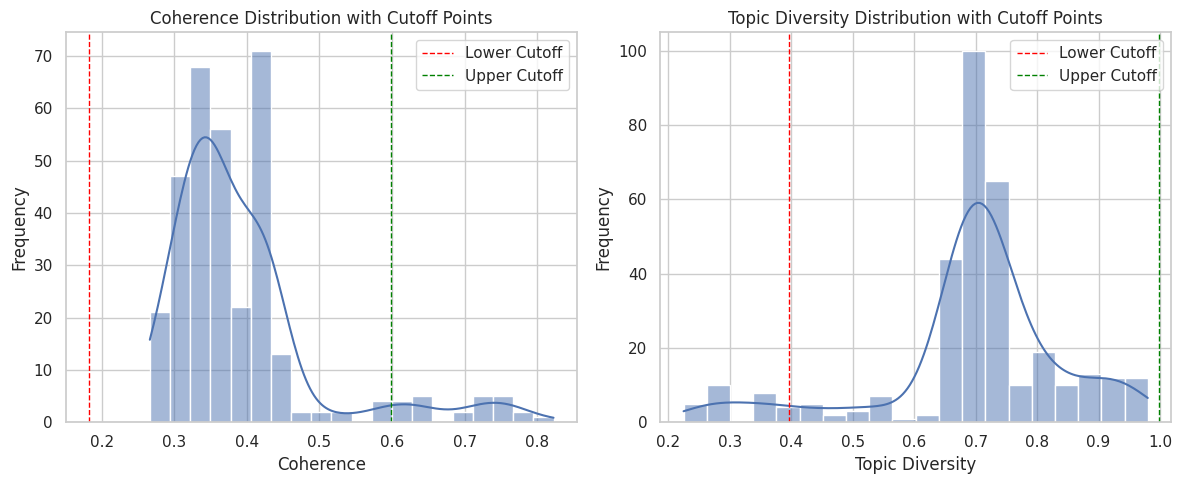

Data after removing outliers:
        Coherence  Topic_Diversity
count  303.000000       303.000000
mean     0.364145         0.732894
std      0.051487         0.098192
min      0.266410         0.400000
25%      0.325831         0.685010
50%      0.352452         0.711111
75%      0.415194         0.753743
max      0.577551         0.980000


In [ ]:
# Step 2: Data Cleaning (Removing Outliers)
# -----------------------------------------
# Explanation:
# We need to remove outliers from the data before analysis, specifically any runs where the metrics are beyond 2 standard deviations from the mean.
# Additionally, we remove runs where Topic Diversity is exactly 1, as this indicates a botched run.

# Remove runs where Topic Diversity or Coherence is exactly 1
df = df[df['Topic_Diversity'] < 1.0]
df = df[df['Coherence'] < 1.0]

# Compute the mean and standard deviation for Coherence and Topic Diversity
coherence_mean = df['Coherence'].mean()
coherence_std = df['Coherence'].std()
topic_diversity_mean = df['Topic_Diversity'].mean()
topic_diversity_std = df['Topic_Diversity'].std()

# Define the upper and lower bounds for acceptable values (within 2 standard deviations)
coherence_lower = coherence_mean - 2 * coherence_std
coherence_upper = coherence_mean + 2 * coherence_std
topic_diversity_lower = topic_diversity_mean - 2 * topic_diversity_std
topic_diversity_upper = topic_diversity_mean + 2 * topic_diversity_std

# Plot the distribution of Coherence with cutoff points
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Coherence'], bins=20, kde=True)
plt.axvline(coherence_lower, color='red', linestyle='dashed', linewidth=1, label='Lower Cutoff')
plt.axvline(coherence_upper, color='green', linestyle='dashed', linewidth=1, label='Upper Cutoff')
plt.title('Coherence Distribution with Cutoff Points')
plt.xlabel('Coherence')
plt.ylabel('Frequency')
plt.legend()

# Plot the distribution of Topic Diversity with cutoff points
plt.subplot(1, 2, 2)
sns.histplot(df['Topic_Diversity'], bins=20, kde=True)
plt.axvline(topic_diversity_lower, color='red', linestyle='dashed', linewidth=1, label='Lower Cutoff')
plt.axvline(topic_diversity_upper, color='green', linestyle='dashed', linewidth=1, label='Upper Cutoff')
plt.title('Topic Diversity Distribution with Cutoff Points')
plt.xlabel('Topic Diversity')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Remove outliers from Coherence
df = df[(df['Coherence'] >= coherence_lower) & (df['Coherence'] <= coherence_upper)]

# Remove outliers from Topic Diversity
df = df[(df['Topic_Diversity'] >= topic_diversity_lower) & (df['Topic_Diversity'] <= topic_diversity_upper)]

# Reset the index after removing outliers
df = df.reset_index(drop=True)

print("Data after removing outliers:")
print(df[['Coherence', 'Topic_Diversity']].describe())


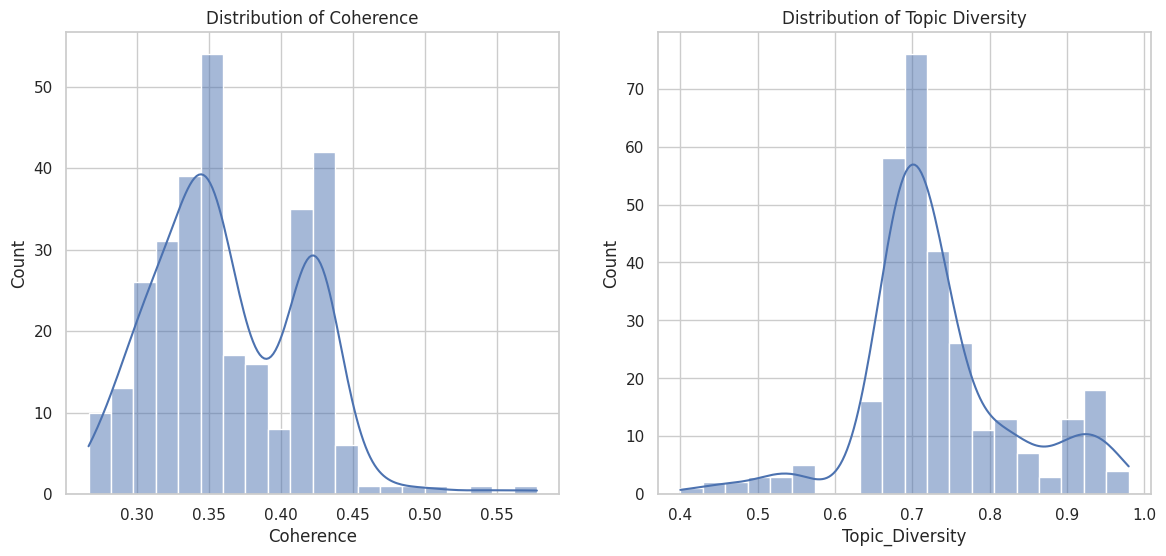

In [ ]:
# Step 3: Exploratory Data Analysis (EDA)
# ---------------------------------------
# Explanation:
# Visualize the distribution of Coherence and Topic Diversity to understand their ranges and variability.

# Histograms of the metrics
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Coherence'], bins=20, kde=True)
plt.title('Distribution of Coherence')

plt.subplot(1, 2, 2)
sns.histplot(df['Topic_Diversity'], bins=20, kde=True)
plt.title('Distribution of Topic Diversity')

plt.show()


In [ ]:
# Step 4: Normalize Metrics
# -------------------------
# Explanation:
# Since the metrics may be on different scales or have different variances, we normalize them to ensure fair weighting.

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the metrics
df[['Coherence_norm', 'Topic_Diversity_norm']] = scaler.fit_transform(df[['Coherence', 'Topic_Diversity']])

# Display the normalized metrics
df[['Coherence_norm', 'Topic_Diversity_norm']].head()


,Coherence_norm,Topic_Diversity_norm
0,0.632624,0.724138
1,0.089060,0.991379
2,0.521849,0.472085
3,0.072662,0.763547
4,0.253942,0.862069


In [ ]:
# Step 5: Combine Metrics with Configurable Weights
# -------------------------------------------------
# Explanation:
# Compute a combined score for each run based on the normalized metrics and configurable weights.

# Define weights for the metrics (equal weight by default)
weight_coherence = 0.5
weight_topic_diversity = 0.5

# Compute the combined score
df['Combined_Score'] = (weight_coherence * df['Coherence_norm']) + (weight_topic_diversity * df['Topic_Diversity_norm'])

# Display the combined scores
df[['Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']].head()


,Coherence_norm,Topic_Diversity_norm,Combined_Score
0,0.632624,0.724138,0.678381
1,0.089060,0.991379,0.540220
2,0.521849,0.472085,0.496967
3,0.072662,0.763547,0.418104
4,0.253942,0.862069,0.558006


In [ ]:
# Step 6: Identify the Best Models
# --------------------------------
# Explanation:
# Rank the runs based on the combined score and select the top-performing models.

# Rank the DataFrame based on the combined score
df_sorted = df.sort_values(by='Combined_Score', ascending=False).reset_index(drop=True)

# Display the top 5 models
top_n = 5
print(f"Top {top_n} Models Based on Combined Score:")
display(df_sorted.head(top_n))


Top 5 Models Based on Combined Score:


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score
0,paraphrase-MiniLM-L6-v2,19,0.425237,0.94,64,27,143,32,0.085702,9,44,0.005932,0.510467,0.931034,0.720751
1,paraphrase-mpnet-base-v2,0,0.463245,0.82,127,31,494,28,0.058341,10,11,0.007313,0.632624,0.724138,0.678381
2,paraphrase-mpnet-base-v2,14,0.469187,0.80,63,22,500,72,0.077818,9,11,0.009372,0.651721,0.689655,0.670688
3,multi-qa-mpnet-base-cos-v1,26,0.402483,0.90,58,18,478,30,0.069975,8,19,0.008625,0.437334,0.862069,0.649702
4,paraphrase-mpnet-base-v2,13,0.452912,0.80,14,18,497,32,0.086975,8,9,0.009857,0.599414,0.689655,0.644535


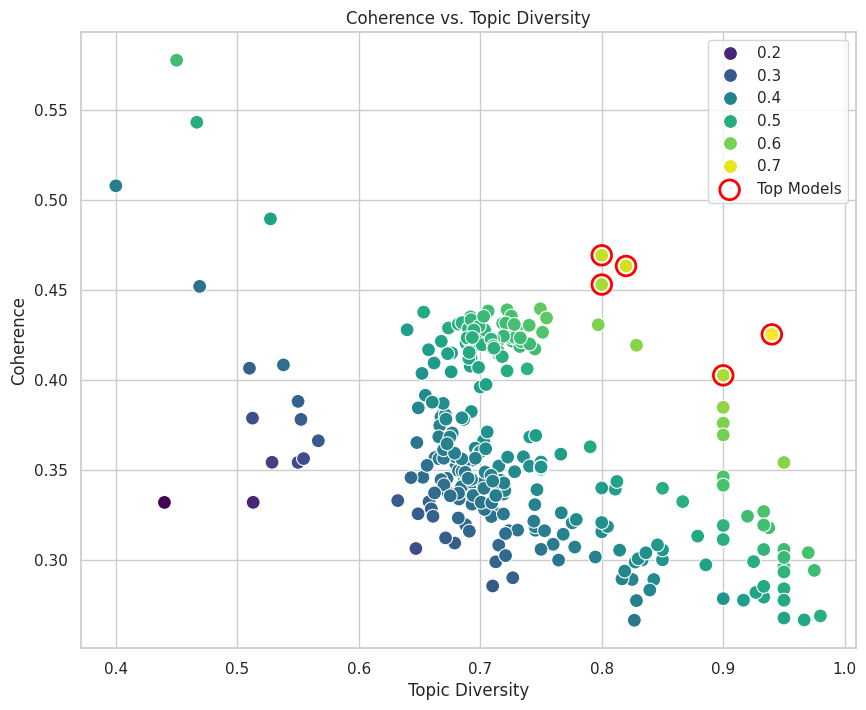

In [ ]:
# Step 7: Visualization of Metrics
# --------------------------------
# Explanation:
# Create a scatter plot of Coherence vs. Topic Diversity, highlighting the top models.

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df, x='Topic_Diversity', y='Coherence', hue='Combined_Score', palette='viridis', s=100)

# Highlight the top models
top_models = df_sorted.head(top_n)
plt.scatter(top_models['Topic_Diversity'], top_models['Coherence'], facecolors='none', edgecolors='red', s=200, linewidths=2, label='Top Models')

plt.title('Coherence vs. Topic Diversity')
plt.xlabel('Topic Diversity')
plt.ylabel('Coherence')
plt.legend()
plt.show()


In [ ]:
# Step 8: Analyze Hyperparameters of Top Models
# ---------------------------------------------
# Explanation:
# Examine the hyperparameters of the top models to understand what configurations yield better performance.

# Extract hyperparameters of the top models
hyperparameters = ['bertopic__min_topic_size', 'bertopic__top_n_words', 'hdbscan__min_cluster_size',
                   'hdbscan__min_samples', 'umap__min_dist', 'umap__n_components', 'umap__n_neighbors',
                   'vectorizer__min_df']

top_models_hyperparams = top_models[hyperparameters + ['Combined_Score']]

print("Hyperparameters of Top Models:")
display(top_models_hyperparams)


Hyperparameters of Top Models:


,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Combined_Score
0,64,27,143,32,0.085702,9,44,0.005932,0.720751
1,127,31,494,28,0.058341,10,11,0.007313,0.678381
2,63,22,500,72,0.077818,9,11,0.009372,0.670688
3,58,18,478,30,0.069975,8,19,0.008625,0.649702
4,14,18,497,32,0.086975,8,9,0.009857,0.644535


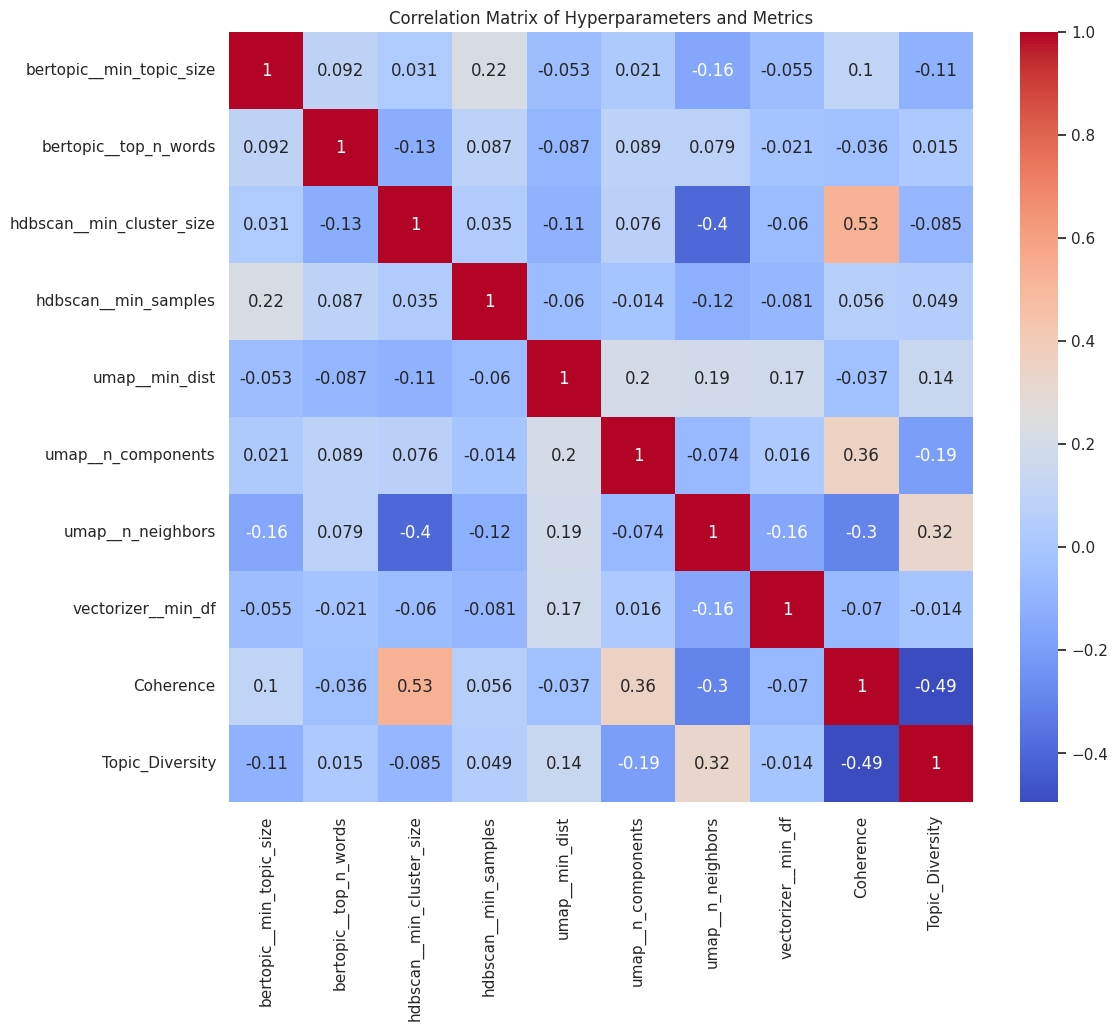

In [ ]:
# Step 9: Correlation Analysis
# ----------------------------
# Explanation:
# Analyze the correlation between hyperparameters and metrics to understand their relationships.

# Compute the correlation matrix
corr_matrix = df[hyperparameters + ['Coherence', 'Topic_Diversity']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Hyperparameters and Metrics')
plt.show()


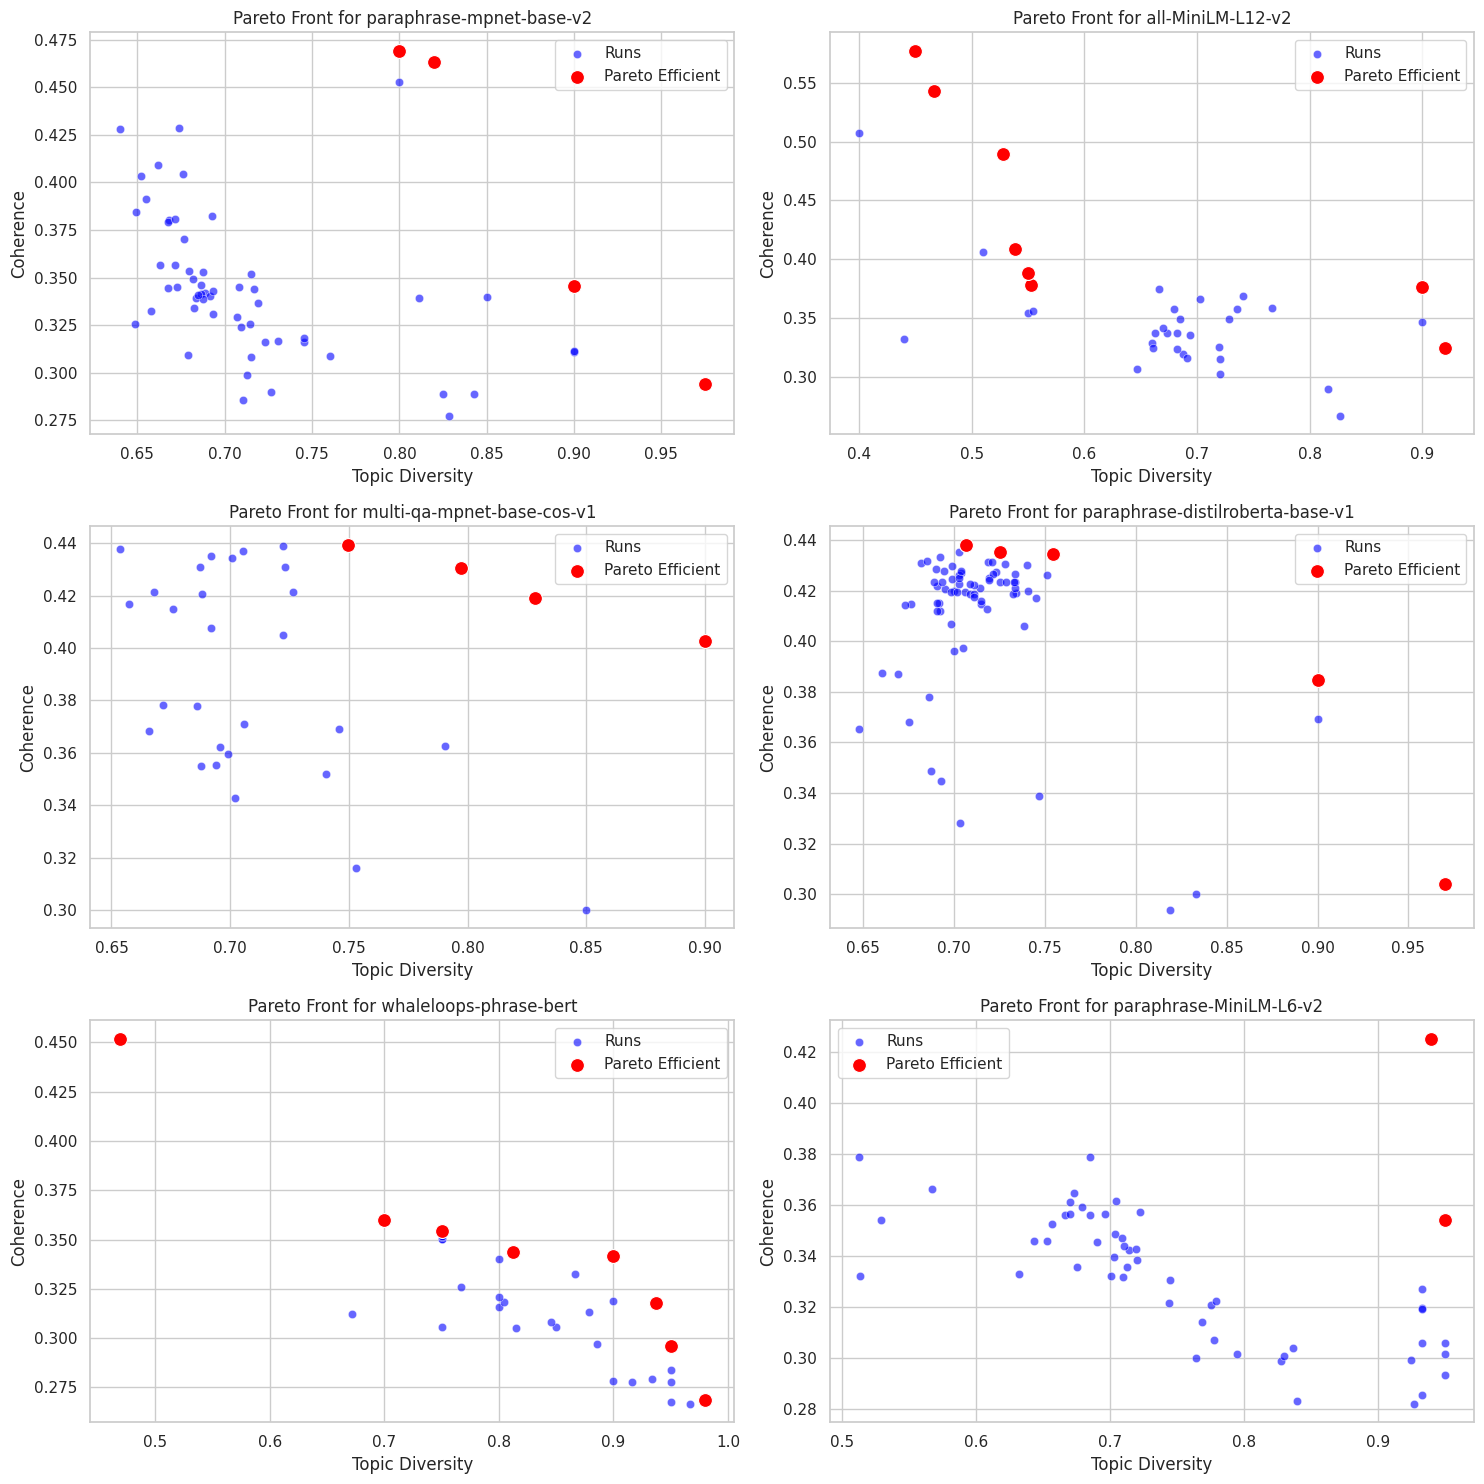

In [ ]:
# Step 10: Pareto Front Analysis (Overall and Per Embedding Model)
# ----------------------------------------------------------------
# Explanation:
# We will perform Pareto front analysis both across all models and separately for each embedding model.
# This helps in identifying optimal runs within each embedding model and understanding their trade-offs.

# Function to identify Pareto-efficient points
def identify_pareto(data):
    # Sort the data by Coherence in descending order
    sorted_data = data.sort_values(by='Coherence_norm', ascending=False)
    pareto_efficient = []
    current_max = -np.inf
    for index, row in sorted_data.iterrows():
        if row['Topic_Diversity_norm'] > current_max:
            pareto_efficient.append(True)
            current_max = row['Topic_Diversity_norm']
        else:
            pareto_efficient.append(False)
    # Assign the Pareto-efficient flag
    sorted_data['Pareto_Efficient'] = pareto_efficient
    # Return the DataFrame with Pareto_Efficient flag
    return sorted_data.sort_index()

# Apply Pareto front identification across all models
df['Pareto_Efficient_All'] = identify_pareto(df[['Coherence_norm', 'Topic_Diversity_norm']])['Pareto_Efficient']

# Now, apply Pareto front identification within each Embeddings_Model
df['Pareto_Efficient_PerModel'] = False  # Initialize the column

# Group the DataFrame by 'Embeddings_Model' and apply Pareto identification
for model_name, group in df.groupby('Embeddings_Model'):
    pareto_flags = identify_pareto(group[['Coherence_norm', 'Topic_Diversity_norm']])['Pareto_Efficient']
    df.loc[group.index, 'Pareto_Efficient_PerModel'] = pareto_flags

# Plotting Pareto Fronts

# Determine the number of unique embedding models
unique_models = df['Embeddings_Model'].unique()
num_models = len(unique_models)

# Define the grid size for plotting
cols = 2
rows = math.ceil(num_models / cols)

plt.figure(figsize=(15, 5 * rows))

for i, model_name in enumerate(unique_models, 1):
    plt.subplot(rows, cols, i)
    subset = df[df['Embeddings_Model'] == model_name]

    # Scatter plot of all runs
    sns.scatterplot(data=subset, x='Topic_Diversity', y='Coherence', label='Runs', color='blue', alpha=0.6)

    # Highlight Pareto-efficient runs
    pareto_subset = subset[subset['Pareto_Efficient_PerModel']]
    sns.scatterplot(data=pareto_subset, x='Topic_Diversity', y='Coherence', label='Pareto Efficient', color='red', s=100)

    plt.title(f'Pareto Front for {model_name}')
    plt.xlabel('Topic Diversity')
    plt.ylabel('Coherence')
    plt.legend()

plt.tight_layout()
plt.show()

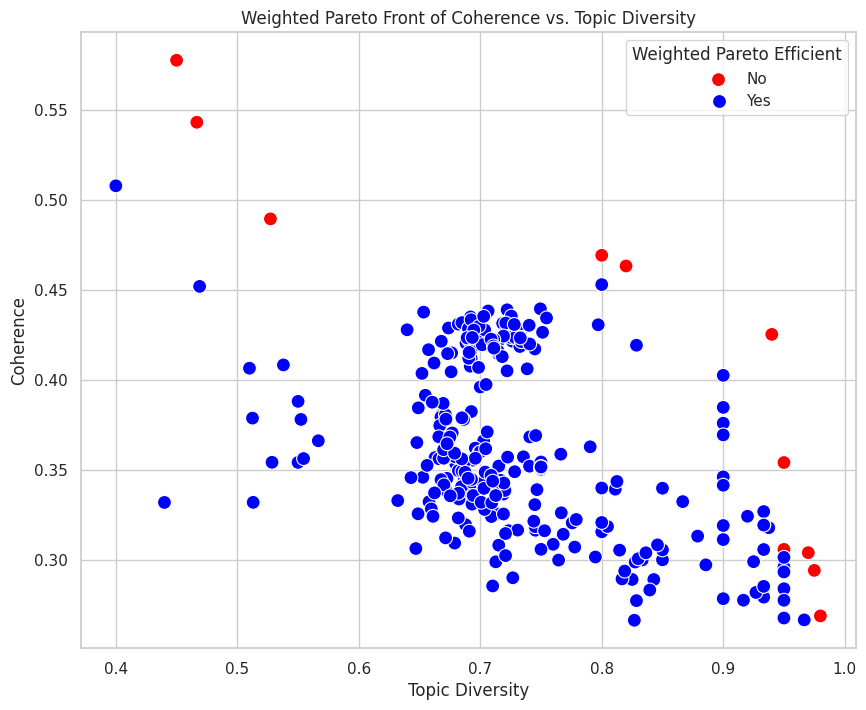

Number of Weighted Pareto-efficient Models: 11


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score,Pareto_Efficient_All,Pareto_Efficient_PerModel,Weighted_Pareto_Efficient
0,paraphrase-mpnet-base-v2,0,0.463245,0.820000,127,31,494,28,0.058341,10,11,0.007313,0.632624,0.724138,0.678381,True,True,True
1,paraphrase-mpnet-base-v2,1,0.294120,0.975000,57,37,132,57,0.053015,4,39,0.004806,0.089060,0.991379,0.540220,True,True,True
6,paraphrase-mpnet-base-v2,14,0.469187,0.800000,63,22,500,72,0.077818,9,11,0.009372,0.651721,0.689655,0.670688,True,True,True
77,all-MiniLM-L12-v2,66,0.577551,0.450000,102,30,281,72,0.005022,2,7,0.001504,1.000000,0.086207,0.543103,True,True,True
78,all-MiniLM-L12-v2,67,0.489419,0.527273,99,24,258,37,0.004852,7,42,0.001174,0.716748,0.219436,0.468092,True,True,True


In [ ]:
# Step 10.1: Weighted Pareto Front Analysis
# ---------------------------------------
# Explanation:
# Identify Pareto-efficient models with higher priority given to Coherence.

# Function to identify Pareto-efficient points with weighted priority
def identify_weighted_pareto(df, weights):
    """
    Identify Pareto-efficient points with weighted priorities.

    Parameters:
    - df: DataFrame containing the metrics.
    - weights: Dictionary containing weights for each metric.

    Returns:
    - A boolean array indicating Pareto-efficient points.
    """
    # Normalize weights
    weight_coherence = weights.get('Coherence_norm', 0.5)
    weight_topic_diversity = weights.get('Topic_Diversity_norm', 0.5)

    # Multiply the normalized metrics by their weights
    weighted_coherence = df['Coherence_norm'] * weight_coherence
    weighted_topic_diversity = df['Topic_Diversity_norm'] * weight_topic_diversity

    # Create a weighted metric DataFrame
    weighted_metrics = pd.DataFrame({
        'Weighted_Coherence': weighted_coherence,
        'Weighted_Topic_Diversity': weighted_topic_diversity
    })

    # Identify Pareto-efficient points
    is_efficient = np.ones(weighted_metrics.shape[0], dtype=bool)
    for i, (wc, wtd) in enumerate(weighted_metrics.values):
        if is_efficient[i]:
            # Any point that is better in both weighted metrics will dominate the current point
            is_efficient[is_efficient] = np.any(weighted_metrics.values[is_efficient] >= [wc, wtd], axis=1)
            is_efficient[i] = True  # Keep the current point
    return is_efficient

# Define weights for the weighted Pareto front
weights = {
    'Coherence_norm': 0.7,
    'Topic_Diversity_norm': 0.3
}

# Identify Pareto-efficient points with weighted priorities
df['Weighted_Pareto_Efficient'] = identify_weighted_pareto(df, weights)

# Plot the Weighted Pareto front
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Topic_Diversity', y='Coherence', hue='Weighted_Pareto_Efficient', palette={True: 'red', False: 'blue'}, s=100)
plt.title('Weighted Pareto Front of Coherence vs. Topic Diversity')
plt.xlabel('Topic Diversity')
plt.ylabel('Coherence')
plt.legend(title='Weighted Pareto Efficient', labels=['No', 'Yes'])
plt.show()

# Display the Pareto-efficient models
pareto_efficient_models = df[df['Weighted_Pareto_Efficient']]
print(f"Number of Weighted Pareto-efficient Models: {pareto_efficient_models.shape[0]}")
display(pareto_efficient_models.head())

In [ ]:
# Step 11: Save the Results
# -------------------------
# Explanation:
# Save the DataFrame with the combined scores and Pareto front information for future reference.

# Save to CSV
df.to_csv('/content/drive/MyDrive/model_evaluation_results.csv', index=False)
print("Results saved to 'model_evaluation_results.csv'.")


Results saved to 'model_evaluation_results.csv'.
